In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib as nm

#from scipy.spatial.distance import pdist, squareform

In [54]:
def rbf_kernel(x, y, h=1):
    # Radial basis function (RBF) kernel
    return np.exp(-np.sum((x - y)**2) / (2 * h**2))

def compute_Kxy(x,h=1):
    # K xy 
    # Dist function for all particles
    # dim(x) = N then we have a ( N x N) size matrix, with ones on the diag. 
       
    N = len(x)
    Kxy = np.zeros((N, N))

    for i in range(N):
        for j in range(i):  # Only compute the lower half
            Kxy[i, j] = rbf_kernel(x[i], x[j], h)

    # Fill in the upper half using symmetry
    Kxy = Kxy + Kxy.T + np.diag(np.ones(N))
    
    return Kxy

def grad_kxy(x, Kxy, h=1):
    dx_kxy = -np.matmul(Kxy,x) 
    sumkxy = np.sum(Kxy,axis=1)

    for i in range(x.shape[1]):
        dx_kxy[:,i] =  dx_kxy[:,i] + ( x[:,i] * sumkxy )
    #dx_kxy /= h**2
    
    return dx_kxy

def svgd_grad_X(x, log_prob_func,):
    x = np.copy(x)
    # Computes phi^star for each time iteration.
    
    log_prob_grad = log_prob_func(x)

    # Compute the kernel matrix 
    Kxy = compute_Kxy(x) 
    dx_Kxy = grad_kxy(x,Kxy) 

    term1 = np.matmul(Kxy, log_prob_grad)
    term2 = dx_Kxy

    grad_x = (( term1 + term2) / x.shape[0]) 

    return grad_x


def svgd_run(x0, d_log_prob_func, n_iter=1, step_size=1e-3, alpha = 1):

    # adagrad with momentum
    fudge_factor = 1e-6

    x = np.copy(x0)
    x_hist = [np.ones_like(x)]*n_iter
    historical_grad =0
    #
    for n in range(n_iter): 
        x_hist[n] = x
        grad_x = svgd_grad_X(x, d_log_prob_func)

        if n ==0: 
            historical_grad = historical_grad + grad_x**2
        else: 
            historical_grad = alpha * historical_grad + (1 - alpha) * (grad_x ** 2)
        
        # force 
        F = np.divide(grad_x, fudge_factor+np.sqrt(historical_grad))

        # update 
        x = x + step_size * F

    return x, x_hist
 

In [3]:
# 1d normal case 
def dlnprob(x):
    mu =1
    var = 5
    return -1*np.log(np.exp((x-mu)*(1.0/var)))

In [4]:
# Testing
x0 = np.random.normal(0,1, [100,1])
#x0 = np.array( [[1.08537042], [0.70810966], [-0.07222987], [-0.55921393], [1.17129406]])

x, xh=svgd_run(x0, dlnprob,1000,0.01)
#print(x)
print("svgd: mu = {} var = {}".format(round(np.mean(x),2), round(np.std(x)**2,2)))


svgd: mu = 0.86 var = 4.56


In [9]:
def plot_results(mu, var, theta, bins=20):
    import matplotlib.pyplot as plt

    count, bins, _ = plt.hist(theta, bins=bins, density=True)
    plt.plot(bins, 1/(np.sqrt(var) * np.sqrt(2 * np.pi)) * 
        np.exp( - (bins - mu)**2 / (2 * np.sqrt(var)**2) ), 
        linewidth=2, color='r')

    plt.show()

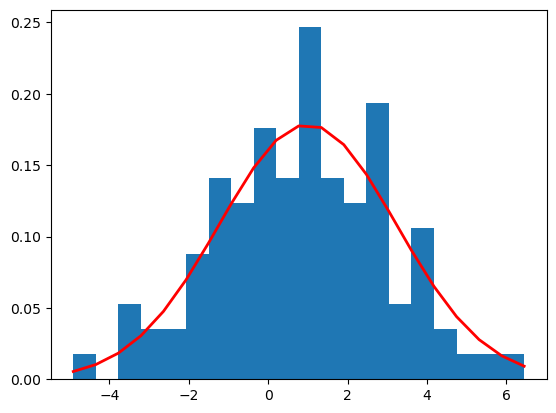

In [10]:
plot_results(1,5,x)

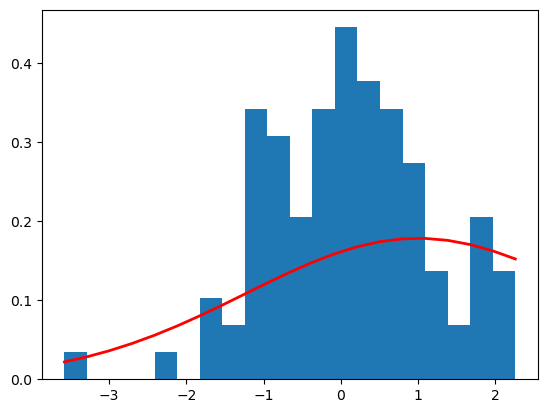

In [52]:
plot_results(1,5,xh[:,0])

In [59]:
def plot_results_line(mu, var, x, bins=20):
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    # Create a KDE object
    #x = x[:,0]
    
    kde = gaussian_kde(x)
    
    # Evaluate the KDE on a grid
    x_grid = np.linspace(min(x), max(x), 100)
    pdf_values = kde(x_grid)
    
    # Plot the original data points as a histogram
    plt.hist(x, bins=30, density=True, alpha=0.5, label='Histogram')
    
    # Plot the estimated PDF using KDE
    plt.plot(x_grid, pdf_values, label='KDE', linewidth=2, color='orange')
    
    plt.xlabel('X-axis')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation (KDE) - 1D')
    plt.legend()
    plt.show()

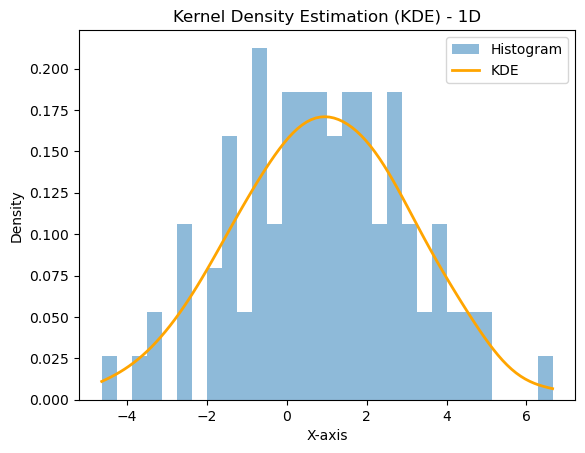

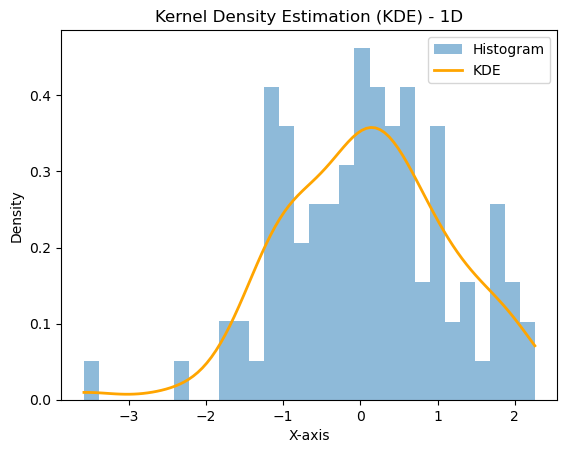

In [60]:
plot_results_line(1,5,x[:,0])
plot_results_line(1,5,xh[:,0])

In [11]:
# Bimodal 
mu1 = -4
var1 = 0.5
mu2 = 2
var2 = 4

def bimodal_gaussian(x, mu, var):
    return np.exp(-np.power(x - mu, 2.) / (2 * var))*1./(np.sqrt(2*np.pi*var))

def bimodal_dlnprob(x):
    return (-1*(x-mu1)*(1/var1)*bimodal_gaussian(x, mu1, var1) - \
            (x-mu2)*(1/var2)*bimodal_gaussian(x, mu2, var2)) / \
            (bimodal_gaussian(x, mu1, var1) + bimodal_gaussian(x, mu2, var2))

In [67]:
def plot_results(mu1, var1, mu2, var2, theta, bins=20):
    from scipy.stats import norm
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()

    counts, bins, _ = plt.hist(theta, bins=bins, density=True)

    # Scale the counts
    scale_factor = 1.0 / 2000 # Calculate the scaling factor
    count = [count * scale_factor for count in counts]

    ax.set_xlim(mu1 - 3*np.sqrt(var1), mu2 + 3*np.sqrt(var2))

    x = np.linspace(mu1 - 3*np.sqrt(var1), mu2 + 3*np.sqrt(var2), 100)
    plt.plot(x, (norm.pdf(x, loc=mu1, scale=np.sqrt(var1)) + norm.pdf(x, loc=mu2, scale=np.sqrt(var2)))/2)

    plt.show()

svgd: mu = 1.44 var = 0.0


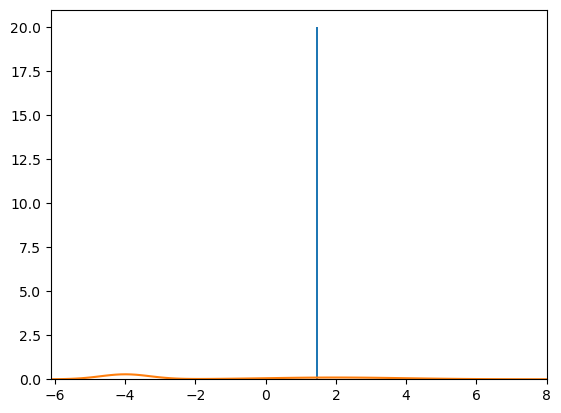

In [68]:
# Testing
x0 = np.random.normal(0,1, [1,1])

x, xh=svgd_run(x0, bimodal_dlnprob,500,0.01)
#print(x)
print("svgd: mu = {} var = {}".format(round(np.mean(x),2), round(np.std(x)**2,2)))

plot_results(mu1, var1, mu2, var2, x)


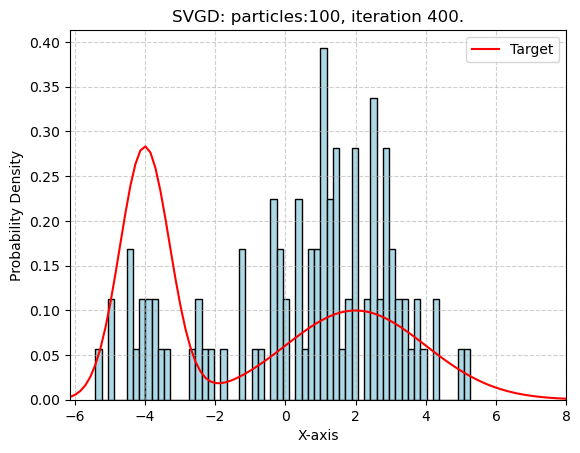

In [32]:
plot_results(mu1, var1, mu2, var2, xh[399])


In [31]:

def plot_results(mu1, var1, mu2, var2, theta, bins=60):
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()

    # Plot histogram
    count, bins, _ = plt.hist(theta, bins=bins, density=True, color='lightblue', edgecolor='black')
    
    # Set x-axis limits
    ax.set_xlim(mu1 - 3*np.sqrt(var1), mu2 + 3*np.sqrt(var2))

    # Plot distribution
    x = np.linspace(mu1 - 3*np.sqrt(var1), mu2 + 3*np.sqrt(var2), 100)
    plt.plot(x, (norm.pdf(x, loc=mu1, scale=np.sqrt(var1)) + norm.pdf(x, loc=mu2, scale=np.sqrt(var2)))/2, color='red', label='Target')

    # Add title
    plt.title('SVGD: particles:100, iteration 400.')

    # Add labels and legend
    plt.xlabel('X-axis')
    plt.ylabel('Probability Density')
    plt.legend()

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)
    #plt.savefig('2d_p100_i400.pdf')

    # Show the plot
    plt.show()

In [33]:
# Unimodal Gaussian 
A = np.array([[2,0],[0,1]])
mu = np.array([2,0])

def unimodal_gaussian_d_log_prob(x):
    return -1*np.matmul(x-nm.repmat(mu, x.shape[0], 1), np.linalg.inv(A))


In [52]:
# test 
np.random.seed(10)
x0 = np.random.normal(0,1, [100,2]);
xx, xh=svgd_run(x0, unimodal_gaussian_d_log_prob,400,0.01)


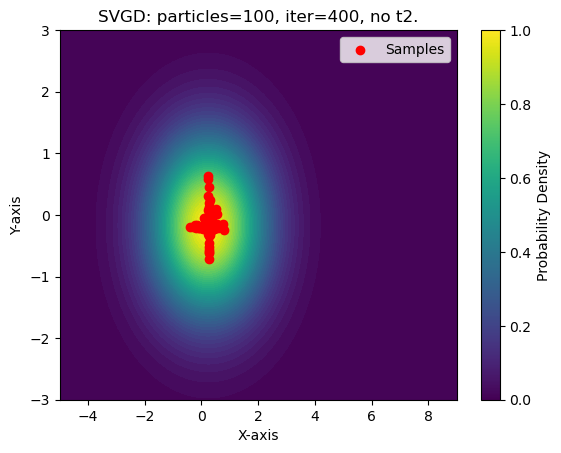

Mean (mu): [ 0.23263894 -0.16709681]
Variance (var): [0.03498088 0.03840011]


In [53]:
# Create a meshgrid for the gradient plot
x, y = np.meshgrid(np.linspace(-5, 9, 100), np.linspace(-3, 3, 100))
pos = np.vstack((x.flatten(), y.flatten())).T

# Calculate the Gaussian values
z = np.exp(-0.5 * np.sum((pos - mu) @ np.linalg.inv(A) * (pos - mu), axis=1))
z = z.reshape(100, 100)

# Plot the gradient plot
plt.contourf(x, y, z, cmap='viridis', levels=50)

# Scatter plot of x0
plt.scatter(xx[:, 0], xx[:, 1], color='red', label='Samples')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('SVGD: particles=100, iter=400, no t2.')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Probability Density')

# Show the plot
plt.legend()
plt.savefig('3d_p100_i400_no_t2.pdf')
plt.show()

mu = np.mean(xx, axis=0)
var = np.var(xx, axis=0)

print("Mean (mu):", mu)
print("Variance (var):", var)

In [101]:
print(xx)
print(xh)

[[1.35083167 0.69601782]]
[array([[1.3315865 , 0.71527897]]), array([[1.3415855 , 0.70527948]]), array([[1.34654545, 0.70031461]]), array([[1.34900582, 0.69784949]]), array([[1.35022627, 0.69662553]])]


In [91]:
print(xx)
print(xh)


[[1.35142757 0.69541853]]
[[1.3315865  1.34158647]]


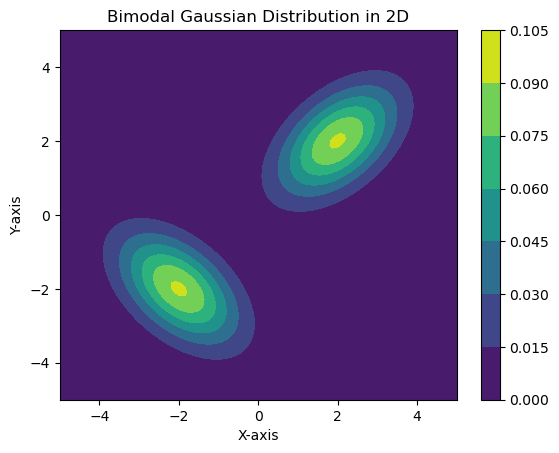

In [105]:
from scipy.stats import multivariate_normal

# Function to generate a bimodal Gaussian distribution in 2D
def bimodal_gaussian_2d(x, y, mean1, cov1, mean2, cov2, weight1, weight2):
    pos = np.dstack((x, y))
    pdf1 = multivariate_normal.pdf(pos, mean1, cov1)
    pdf2 = multivariate_normal.pdf(pos, mean2, cov2)
    return weight1 * pdf1 + weight2 * pdf2

# Parameters for the bimodal Gaussian distribution in 2D
mean1 = np.array([2, 2])
cov1 = np.array([[1, 0.5], [0.5, 1]])

mean2 = np.array([-2, -2])
cov2 = np.array([[1, -0.5], [-0.5, 1]])

weight1 = 0.5
weight2 = 0.5

# Generate data points
x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
z = bimodal_gaussian_2d(x, y, mean1, cov1, mean2, cov2, weight1, weight2)

# Plot the bimodal Gaussian distribution in 2D
plt.contourf(x, y, z, cmap='viridis')
plt.title('Bimodal Gaussian Distribution in 2D')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()
plt.show()

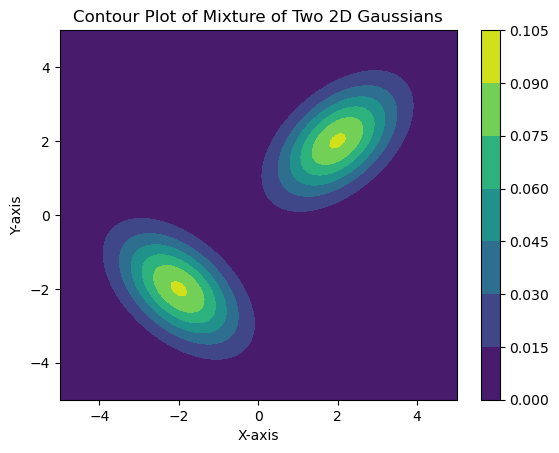

In [107]:

# Parameters for the mixture of two 2D Gaussians
pi1 = 0.5
pi2 = 0.5

mean1 = np.array([2, 2])
cov1 = np.array([[1, 0.5], [0.5, 1]])

mean2 = np.array([-2, -2])
cov2 = np.array([[1, -0.5], [-0.5, 1]])

# Function to compute the mixture of two 2D Gaussians
def mixture_pdf(x, pi1, mean1, cov1, pi2, mean2, cov2):
    pdf1 = multivariate_normal.pdf(x, mean1, cov1)
    pdf2 = multivariate_normal.pdf(x, mean2, cov2)
    return pi1 * pdf1 + pi2 * pdf2

# Generate data points
x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
z = np.zeros_like(x)

# Compute the mixture PDF for each point in the grid
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        point = np.array([x[i, j], y[i, j]])
        z[i, j] = mixture_pdf(point, pi1, mean1, cov1, pi2, mean2, cov2)

# Plot the contour plot
plt.contourf(x, y, z, cmap='viridis')
plt.title('Contour Plot of Mixture of Two 2D Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()
plt.show()

In [114]:

# Parameters for the mixture of two 2D Gaussians
pi1 = 0.5
pi2 = 0.5

mean1 = np.array([2, 2])
cov1 = np.array([[1, 0.5], [0.5, 1]])

mean2 = np.array([-2, -2])
cov2 = np.array([[1, -0.5], [-0.5, 1]])
# Function to compute the derivative of the log PDF with respect to x
def log_prob_derivative_mixture(x):
    print(x)
    pdf1 = multivariate_normal.pdf(x, mean1, cov1)
    pdf2 = multivariate_normal.pdf(x, mean2, cov2)
    
    grad_pdf1 = -np.linalg.inv(cov1).dot(x - mean1)
    grad_pdf2 = -np.linalg.inv(cov2).dot(x - mean2)
    
    numerator1 = pi1 * grad_pdf1
    numerator2 = pi2 * grad_pdf2
    
    denominator = pi1 * pdf1 + pi2 * pdf2
    
    return -(numerator1 + numerator2) / denominator

In [139]:
# Unimodal Gaussian 
A1 = np.array([[1,0],[0,1]])
mu1 = np.array([2,2])

A2 = np.array([[1,0],[0,1]])
mu2 = np.array([-2,-2])

def unimodal_gaussian_d_log_prob(x):
    return -1*np.matmul(x-nm.repmat(mu1, x.shape[0], 1), np.linalg.inv(A1)) -1*np.matmul(x-nm.repmat(mu2, x.shape[0], 1), np.linalg.inv(A2))
    
# test 
np.random.seed(10)
x0 = np.random.normal(0,1, [100,2]);
xx, xh=svgd_run(x0, unimodal_gaussian_d_log_prob,5,0.01)

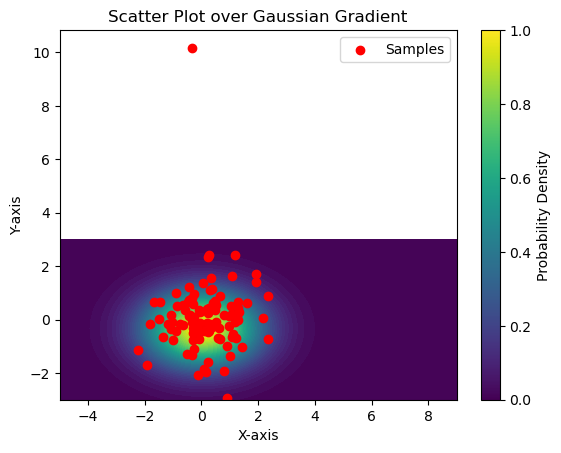

Mean (mu): [0.14564186 0.09153178]
Variance (var): [0.87376431 1.92406583]


In [140]:
# Create a meshgrid for the gradient plot
x, y = np.meshgrid(np.linspace(-5, 9, 100), np.linspace(-3, 3, 100))
pos = np.vstack((x.flatten(), y.flatten())).T

# Calculate the Gaussian values
z = np.exp(-0.5 * np.sum((pos - mu) @ np.linalg.inv(A) * (pos - mu), axis=1))
z = z.reshape(100, 100)

# Plot the gradient plot
plt.contourf(x, y, z, cmap='viridis', levels=50)

# Scatter plot of x0
plt.scatter(xx[:, 0], xx[:, 1], color='red', label='Samples')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot over Gaussian Gradient')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Probability Density')

# Show the plot
plt.legend()
plt.show()

mu = np.mean(xx, axis=0)
var = np.var(xx, axis=0)

print("Mean (mu):", mu)
print("Variance (var):", var)